In [ ]:
import pandas as pd
import folium
#import geopandas as gpd
import plotly.express as px
#import geodatasets
from folium.plugins import HeatMap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from IPython.display import display


# Importing the Dataset  for analysis

In [171]:
# Load the dataset
df = pd.read_csv("weather_data_augmented.csv")
#View the first 10 rows
df.head(10)

,Location,Date_Time,Temperature_C,Humidity_pct,Precipitation_mm,Wind_Speed_kmh,Crop_Yield,Season(Jan-May)
0,San Diego,1/14/2024 21:12,10.683001,41.195754,4.020119,8.233540,0.700000,1
1,San Diego,5/17/2024 15:22,8.734140,58.319107,9.111623,27.715161,0.700000,1
2,San Diego,5/11/2024 9:30,11.632436,38.820175,4.607511,28.732951,0.700000,1
3,Philadelphia,2/26/2024 17:32,-8.628976,54.074474,3.183720,26.367303,0.486592,1
4,San Antonio,4/29/2024 13:23,39.808213,72.899908,9.598282,29.898622,3.697053,1
5,San Diego,1/21/2024 8:54,27.341055,49.023236,9.166543,27.473896,0.700000,1
6,San Jose,1/13/2024 2:10,1.881883,65.742325,0.221709,1.073112,1.575000,1
7,New York,1/25/2024 19:04,-6.894766,30.804894,8.027624,16.848337,1.300000,1
8,New York,3/29/2024 5:20,0.963545,38.819158,3.640129,7.989024,1.300000,1
9,San Jose,5/18/2024 9:14,-1.607088,82.198701,4.101493,25.647282,1.575000,1


# Renaming colum names

In [174]:
# Rename columns
df.rename(columns={
    "Date_Time": "Date",
    "Temperature_C": "Temperature(C)",
    "Humidity_pct": "Humidity(pct)",
    "Precipitation_mm": "Precipitation(mm)",
    "Wind_Speed_kmh": "Wind_Speed(km/h)"
}, inplace=True)


# Removing the time component in the date column

In [177]:
# Remove time from the Date column
df["Date"] = pd.to_datetime(df["Date"]).dt.date

In [179]:
#Check if changes have been applied
df.head(5)

,Location,Date,Temperature(C),Humidity(pct),Precipitation(mm),Wind_Speed(km/h),Crop_Yield,Season(Jan-May)
0,San Diego,2024-01-14,10.683001,41.195754,4.020119,8.233540,0.700000,1
1,San Diego,2024-05-17,8.734140,58.319107,9.111623,27.715161,0.700000,1
2,San Diego,2024-05-11,11.632436,38.820175,4.607511,28.732951,0.700000,1
3,Philadelphia,2024-02-26,-8.628976,54.074474,3.183720,26.367303,0.486592,1
4,San Antonio,2024-04-29,39.808213,72.899908,9.598282,29.898622,3.697053,1


In [181]:
# Dictionary mapping locations to their coordinates
coordinates = {
    'Dallas': (32.7767, -96.7970),
    'Phoenix': (33.4484, -112.0740),
    'San Diego': (32.7157, -117.1611),
    'Chicago': (41.8781, -87.6298),
    'Houston': (29.7604, -95.3698),
    'San Antonio': (29.4241, -98.4936),
    'New York': (40.7128, -74.0060),
    'Philadelphia': (39.9526, -75.1652),
    'San Jose': (37.3382, -121.8863),
    'Los Angeles': (34.0522, -118.2437)
}

In [183]:
aggregated_data = df.groupby('Location').agg({
    'Temperature(C)': 'mean', 
    'Humidity(pct)': 'mean', 
    'Precipitation(mm)': 'sum', 
    'Wind_Speed(km/h)': 'mean'
}).reset_index()

In [185]:
#Add latitude and longitude based on the dictionary
aggregated_data['Latitude'] = aggregated_data['Location'].map(lambda x: coordinates[x][0] if x in coordinates else None)
aggregated_data['Longitude'] = aggregated_data['Location'].map(lambda x: coordinates[x][1] if x in coordinates else None)


In [187]:
#Filter the DataFrame to include only specified locations
filtered_data = aggregated_data[aggregated_data['Location'].isin(coordinates.keys())]

# Create a Folium map centered around North America
m = folium.Map(location=[37.0, -95.0], zoom_start=4)  # Centered on the continental US

# Define colors for each location
color_map = {
    'Dallas': 'blue',
    'Phoenix': 'orange',
    'San Diego': 'green',
    'Chicago': 'red',
    'Houston': 'purple',
    'San Antonio': 'darkblue',
    'New York': 'darkgreen',
    'Philadelphia': 'darkred',
    'San Jose': 'black',
    'Los Angeles': 'yellow'
}

# Add markers for each location with specific colors
for _, row in filtered_data.iterrows():
    if row['Location'] in color_map:
        folium.Marker(
            location=[coordinates[row['Location']][0], coordinates[row['Location']][1]],
            popup=f"Location: {row['Location']}<br>"
                  f"Temp: {row['Temperature(C)']:.1f} °C<br>"
                  f"Humidity: {row['Humidity(pct)']:.1f} %<br>"
                  f"Precipitation: {row['Precipitation(mm)']:.1f} mm<br>"
                  f"Wind Speed: {row['Wind_Speed(km/h)']:.1f} km/h",
            icon=folium.Icon(color=color_map[row['Location']])
        ).add_to(m)

# Add a legend to the map with clickable links
legend_html = '''
<div style="position: fixed; 
            top: 10px; left: 10px; width: 150px; height: auto; 
            border:2px solid grey; z-index:1000; font-size:14px;
            background-color: white;">
    <p style="text-align: center; font-weight: bold;">Locations Legend</p>
'''

# Add clickable locations to the legend
for location, color in color_map.items():
    lat, lon = coordinates[location]
    legend_html += f'<p><a href="#" onclick="map.setView([{lat}, {lon}], 8);" style="color: {color};">{location}</a></p>'

legend_html += '</div>'

# Add the legend to the map
m.get_root().html.add_child(folium.Element(legend_html))

# Display the map in a Jupyter Notebook
display(m)

# Save the map to an HTML file (optional)
m.save('weather_analysis_map.html')

C:\Users\user\AppData\Local\Temp\ipykernel_17404\2506286546.py:31: UserWarning:

color argument of Icon should be one of: {'lightred', 'lightgreen', 'beige', 'blue', 'lightgray', 'cadetblue', 'gray', 'purple', 'red', 'darkred', 'darkblue', 'darkpurple', 'lightblue', 'darkgreen', 'orange', 'black', 'green', 'white', 'pink'}.



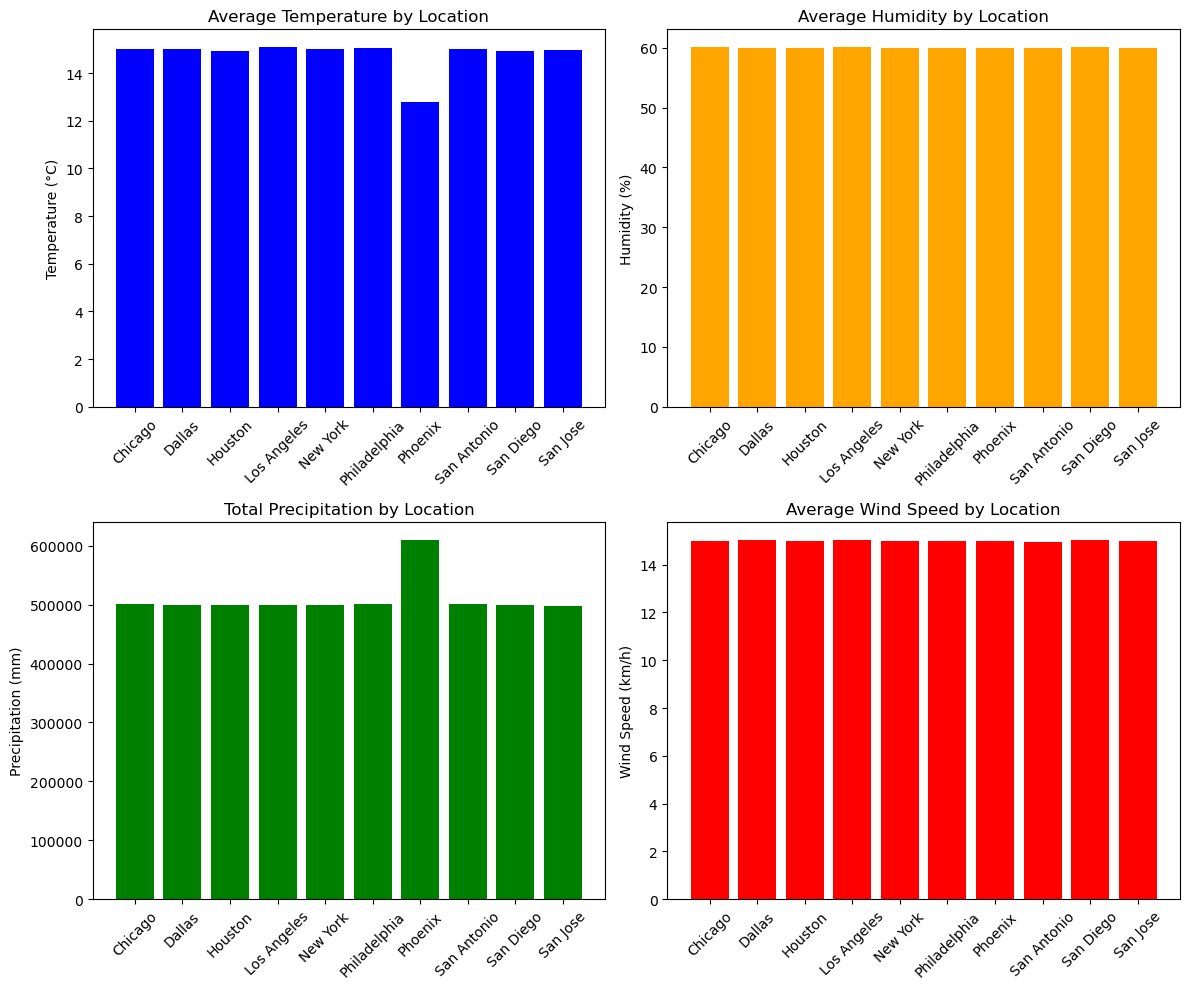

In [189]:
# Create a standalone Matplotlib map
# Generate a bar chart for the aggregated data
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Temperature
axs[0, 0].bar(filtered_data['Location'], filtered_data['Temperature(C)'], color='blue')
axs[0, 0].set_title('Average Temperature by Location')
axs[0, 0].set_ylabel('Temperature (°C)')
axs[0, 0].tick_params(axis='x', rotation=45)

# Humidity
axs[0, 1].bar(filtered_data['Location'], filtered_data['Humidity(pct)'], color='orange')
axs[0, 1].set_title('Average Humidity by Location')
axs[0, 1].set_ylabel('Humidity (%)')
axs[0, 1].tick_params(axis='x', rotation=45)

# Precipitation
axs[1, 0].bar(filtered_data['Location'], filtered_data['Precipitation(mm)'], color='green')
axs[1, 0].set_title('Total Precipitation by Location')
axs[1, 0].set_ylabel('Precipitation (mm)')
axs[1, 0].tick_params(axis='x', rotation=45)

# Wind Speed
axs[1, 1].bar(filtered_data['Location'], filtered_data['Wind_Speed(km/h)'], color='red')
axs[1, 1].set_title('Average Wind Speed by Location')
axs[1, 1].set_ylabel('Wind Speed (km/h)')
axs[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()

# Save the Matplotlib figure to an image file
matplotlib_map_file = 'weather_analysis_map.png'
plt.savefig(matplotlib_map_file)
plt.show()

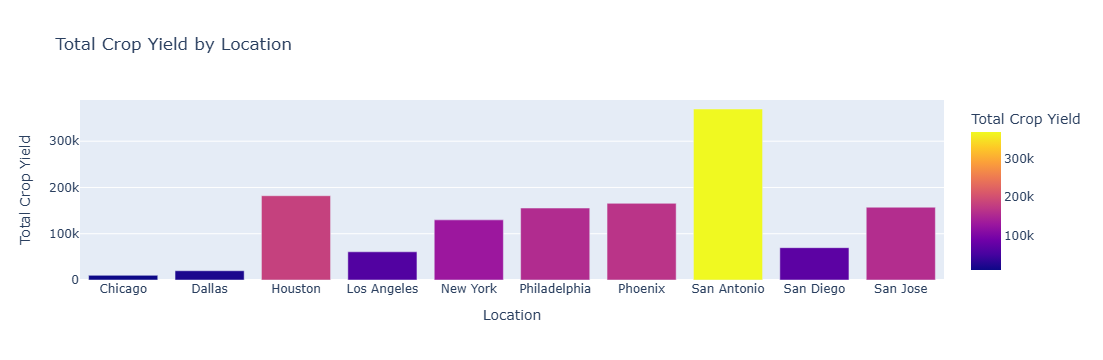

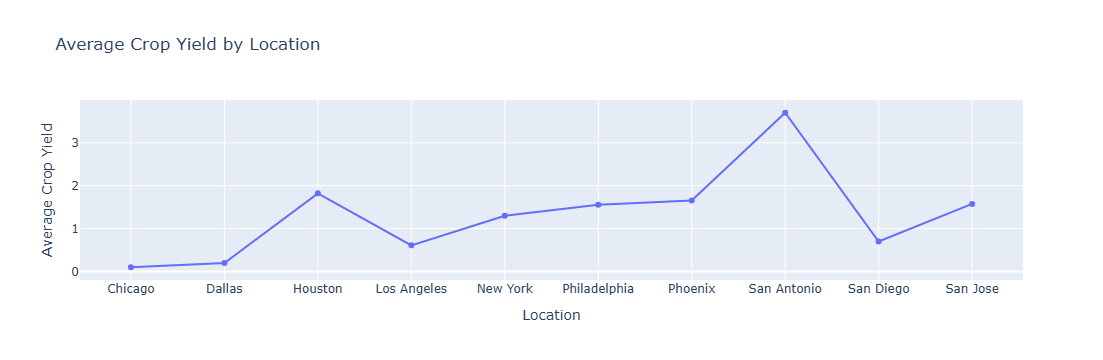

In [190]:
total_yield = df.groupby('Location')['Crop_Yield'].sum().reset_index()

#Create a bar graph for total crop yield by location
fig_total_yield = px.bar(total_yield, 
                          x='Location', 
                          y='Crop_Yield', 
                          title='Total Crop Yield by Location',
                          labels={'Crop_Yield': 'Total Crop Yield'},
                          color='Crop_Yield',
                          color_continuous_scale=px.colors.sequential.Plasma)

#Calculate average crop yield by location for the line graph
average_yield = df.groupby('Location')['Crop_Yield'].mean().reset_index()

# Create a line graph for average crop yield by location
fig_yield_trend = px.line(average_yield, 
                           x='Location', 
                           y='Crop_Yield', 
                           title='Average Crop Yield by Location',
                           labels={'Crop_Yield': 'Average Crop Yield'},
                           markers=True)

# Show the figures
fig_total_yield.show()
fig_yield_trend.show()

                   Date_Ordinal  Temperature(C)  Humidity(pct)  \
Date_Ordinal           1.000000        0.016563      -0.000240   
Temperature(C)         0.016563        1.000000      -0.001344   
Humidity(pct)         -0.000240       -0.001344       1.000000   
Precipitation(mm)     -0.036360       -0.010876      -0.000264   
Wind_Speed(km/h)       0.000143       -0.001273      -0.000642   

                   Precipitation(mm)  Wind_Speed(km/h)  
Date_Ordinal               -0.036360          0.000143  
Temperature(C)             -0.010876         -0.001273  
Humidity(pct)              -0.000264         -0.000642  
Precipitation(mm)           1.000000          0.000981  
Wind_Speed(km/h)            0.000981          1.000000  


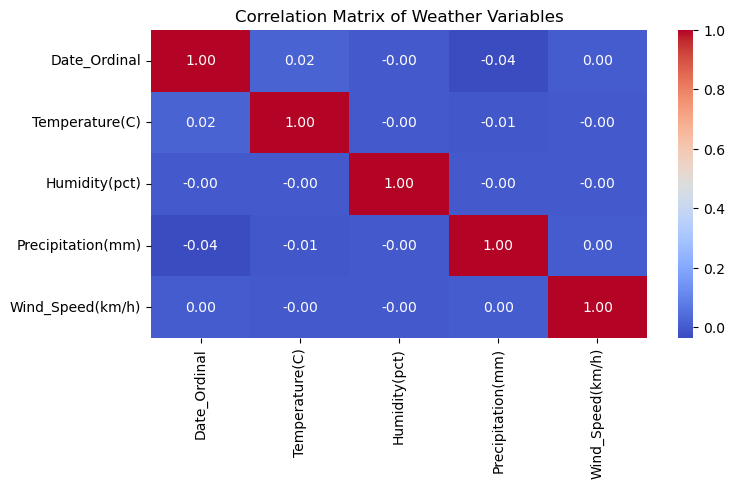

In [193]:
# Ensure the 'Date' column is in datetime format (specifically for mm/dd/yyyy format)
df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y', errors='coerce')

# Check for any rows that could not be converted
if df['Date'].isnull().any():
    print("Warning: Some dates could not be parsed. Check the data for inconsistencies.")

# Select relevant columns for correlation analysis
correlation_data = df[['Date', 'Temperature(C)', 'Humidity(pct)', 'Precipitation(mm)', 'Wind_Speed(km/h)']].copy()

# Convert 'Date' to ordinal for correlation calculation
correlation_data['Date_Ordinal'] = correlation_data['Date'].map(pd.Timestamp.toordinal)

# Calculate the correlation matrix
correlation_matrix = correlation_data[['Date_Ordinal', 'Temperature(C)', 'Humidity(pct)', 'Precipitation(mm)', 'Wind_Speed(km/h)']].corr()

# Display the correlation matrix
print(correlation_matrix)

# Create a heatmap for better visualization
plt.figure(figsize=(8, 4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Weather Variables')
plt.show()

                   Temperature(C)  Humidity(pct)  Precipitation(mm)  \
Temperature(C)           1.000000      -0.159021          -0.997210   
Humidity(pct)           -0.159021       1.000000           0.176090   
Precipitation(mm)       -0.997210       0.176090           1.000000   
Wind_Speed(km/h)         0.185210       0.516589          -0.176747   
Crop_Yield              -0.112491      -0.606916           0.115008   

                   Wind_Speed(km/h)  Crop_Yield  
Temperature(C)             0.185210   -0.112491  
Humidity(pct)              0.516589   -0.606916  
Precipitation(mm)         -0.176747    0.115008  
Wind_Speed(km/h)           1.000000   -0.784323  
Crop_Yield                -0.784323    1.000000  


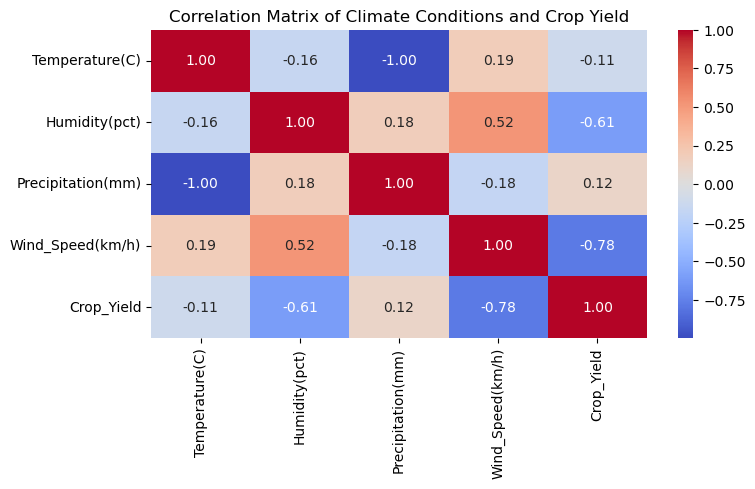

In [194]:
# Group by location and calculate average climate conditions and crop yield
average_conditions = df.groupby('Location').agg({
    'Temperature(C)': 'mean',
    'Humidity(pct)': 'mean',
    'Precipitation(mm)': 'mean',
    'Wind_Speed(km/h)': 'mean',
    'Crop_Yield': 'mean'  # Assuming Crop_Yield is also available per location
}).reset_index()

# Calculate the correlation matrix
correlation_matrix = average_conditions[['Temperature(C)', 'Humidity(pct)', 'Precipitation(mm)', 'Wind_Speed(km/h)', 'Crop_Yield']].corr()

# Display the correlation matrix
print(correlation_matrix)

# Create a heatmap for better visualization
plt.figure(figsize=(8, 4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Climate Conditions and Crop Yield')
plt.show()

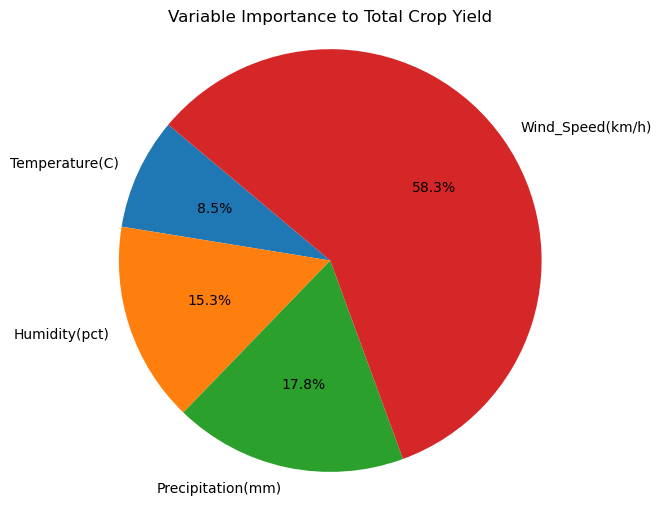

In [195]:
# Prepare input features (X) and target variable (y)
X = average_conditions[['Temperature(C)', 'Humidity(pct)', 'Precipitation(mm)', 'Wind_Speed(km/h)']]
y = average_conditions['Crop_Yield']

# Fit a linear regression model
model = LinearRegression()
model.fit(X, y)

# Get the coefficients and feature names
coefficients = model.coef_
features = X.columns

# Create a DataFrame for variable importance
importance_df = pd.DataFrame({'Feature': features, 'Importance': coefficients})

# Use absolute values for importance
importance_df['Importance'] = importance_df['Importance'].abs()
importance_df['Importance'] = importance_df['Importance'] / importance_df['Importance'].sum()  # Normalize importance

# Plot the pie chart
plt.figure(figsize=(6, 6))
plt.pie(importance_df['Importance'], labels=importance_df['Feature'], autopct='%1.1f%%', startangle=140)
plt.title('Variable Importance to Total Crop Yield')
plt.axis('equal')  # Equal aspect ratio ensures the pie chart is circular
plt.show()

# Simulating large dataset challenges: Trend Analysis of weather conditions by date

In [ ]:

#df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y', errors='coerce')

# Set the date as the index
df.set_index('Date', inplace=True)

# Plotting
plt.figure(figsize=(14, 7))

# Plot each variable using the renamed columns
plt.plot(df.index, df['Temperature(C)'], label='Temperature (°C)', color='red', linewidth=2)
plt.plot(df.index, df['Humidity(pct)'], label='Humidity (%)', color='blue', linewidth=2)
plt.plot(df.index, df['Precipitation(mm)'], label='Precipitation (mm)', color='green', linewidth=2)
plt.plot(df.index, df['Wind_Speed(km/h)'], label='Wind Speed (km/h)', color='orange', linewidth=2)

# Adding titles and labels
plt.title('Trend Analysis of Weather Variables Over Time', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Values', fontsize=14)
plt.legend()
plt.grid()

# Show plot
plt.tight_layout()
plt.show()

C:\Users\user\AppData\Local\Temp\ipykernel_17404\4080959297.py:23: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.

C:\Users\user\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.



In [ ]:
# Select the first 20 samples
df_subset = df.head(20)

# Plotting
plt.figure(figsize=(14, 7))

# Plot each variable 
plt.plot(df_subset.index, df_subset['Temperature(C)'], label='Temperature (°C)', color='red', linewidth=2)
plt.plot(df_subset.index, df_subset['Humidity(pct)'], label='Humidity (%)', color='blue', linewidth=2)
plt.plot(df_subset.index, df_subset['Precipitation(mm)'], label='Precipitation (mm)', color='green', linewidth=2)
plt.plot(df_subset.index, df_subset['Wind_Speed(km/h)'], label='Wind Speed (km/h)', color='orange', linewidth=2)

# Adding titles and labels
plt.title('Trend Analysis of Weather Variables (First 20 Samples)', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Values', fontsize=14)
plt.legend(loc='upper right')
plt.grid()

# Show plot
plt.tight_layout()
plt.show()